**Unzip data**

In [1]:
import os
import py7zr

In [2]:
'''

zip_path='Handwritten.7z'
extract_path='Handwritten_equations'

with py7zr.SevenZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(extract_path)

''' 

"\n\nzip_path='Handwritten.7z'\nextract_path='Handwritten_equations'\n\nwith py7zr.SevenZipFile(zip_path,'r') as zip_ref:\n    zip_ref.extractall(extract_path)\n\n"

**Making Charector Dictionary**

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import Dataset , DataLoader

In [4]:
image_folder="Handwritten_equations/Handwritten/Dataset"
df=pd.read_csv('caption_data.csv')

In [5]:
import json

# Extract all characters from the labels
all_text = "".join(df["Column2"].astype(str))  # Convert all text into a single string

# Get unique characters and create dictionary
unique_chars = sorted(set(all_text))
char_dict = {char: idx for idx, char in enumerate(unique_chars)}

# Save dictionary for later use
with open("char_dict.json", "w", encoding="utf-8") as f:
    json.dump(char_dict, f, indent=4, ensure_ascii=False)

print("Character dictionary created")


Character dictionary created


In [7]:
df.sample(5)
value = df.loc[df['Column1'] == '29_em_167', df.columns[1]].values[0]
print(value)

\cos ( n x ) = 2 \cos ( x ) \cos [ ( n - 1 ) x ] - \cos [ ( n - 2 ) x ]


**Encoding labels**

In [8]:
# Encoding of Latex labels
def encode_label(label, char_dict):
    return [char_dict[char] for char in label if char in char_dict]

df["Column2"] = df["Column2"].apply(lambda x: encode_label(x, char_dict))

print("Example encoded label:", df["Column2"].iloc[0])


Example encoded label: [70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 5, 0, 71, 0, 46, 0, 73, 0, 57, 0, 75, 0, 71, 0, 70, 0, 46, 0, 73, 0, 57, 0, 75]


In [9]:
df.head()

,Column1,Column2
0,18_em_0,"[70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70,..."
1,18_em_10,"[12, 0, 16]"
2,18_em_11,"[63, 0, 46, 0, 73, 0, 66, 0, 75, 0, 21, 0, 12,..."
3,18_em_12,"[43, 52, 64, 47, 49, 0, 73, 0, 62, 0, 51, 0, 4..."
4,18_em_13,"[14, 0, 45, 0, 73, 0, 12, 0, 75, 0, 5, 0, 14, ..."


**Matching the name of image**

In [10]:
# Modyfing the name of images
df["Column1"] = df["Column1"].astype(str) + ".bmp"
df.head()

,Column1,Column2
0,18_em_0.bmp,"[70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70,..."
1,18_em_10.bmp,"[12, 0, 16]"
2,18_em_11.bmp,"[63, 0, 46, 0, 73, 0, 66, 0, 75, 0, 21, 0, 12,..."
3,18_em_12.bmp,"[43, 52, 64, 47, 49, 0, 73, 0, 62, 0, 51, 0, 4..."
4,18_em_13.bmp,"[14, 0, 45, 0, 73, 0, 12, 0, 75, 0, 5, 0, 14, ..."


**Dataset class**

In [11]:
class Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        print("Initial DataFrame size:", len(self.df))

        # Filter out rows where the image does not exist
        self.df = self.df[self.df.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))].reset_index(drop=True)

        print("Final DataFrame size:", len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_name)

        
        image = Image.open(img_path)

        label = self.df.iloc[index, -1]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label
        

**Dataset**

In [12]:
# This transforms this image to tensor

mean=[0.4363]
std=[0.2129]
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Create dataset
dataset=Dataset(df=df,img_dir=image_folder,transform=transform)

Initial DataFrame size: 12167
Final DataFrame size: 12167


**Managing the variable lenght**

In [13]:
# Manage the variable lenght of label

def custom_collate_fn(batch):
    images, labels = zip(*batch)  # Unzip images and labels

    # Stack images into a batch tensor
    images = torch.stack(images, dim=0)

    # Convert each label tensor to a list (to allow list operations)
    labels = [label.tolist() if isinstance(label, torch.Tensor) else label for label in labels]

    # Find max length of label in the batch
    max_len = max(len(label) for label in labels)

    # Pad labels with 0 (or another padding token if needed)
    padded_labels = [label + [0] * (max_len - len(label)) for label in labels]

    # Convert labels to tensor
    labels_tensor = torch.tensor(padded_labels, dtype=torch.long)

    return images, labels_tensor  # Labels are now a padded tensor


**Use of DataLoader**

In [14]:
from torch.utils.data import random_split
train_ratio=0.8
train_size=int(train_ratio*len(dataset))
test_size=len(dataset)-train_size

train_data,test_data=random_split(dataset,[train_size,test_size])

In [15]:
batch_size=8
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True,collate_fn=custom_collate_fn)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,pin_memory=True,collate_fn=custom_collate_fn)

**Visulisation of one tensor from test**

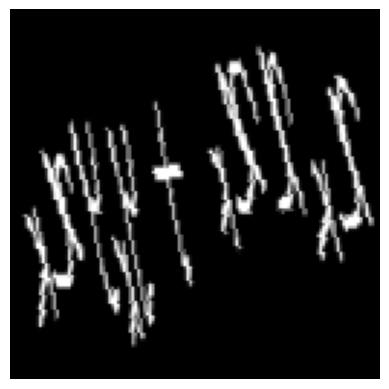

Label (LaTeX format): tensor([70,  0, 46,  0, 73,  0, 57,  0, 75,  0, 70,  0, 70,  0, 46,  0, 73,  0,
        57,  0, 75,  0,  5,  0, 71,  0, 46,  0, 73,  0, 57,  0, 75,  0, 71,  0,
        70,  0, 46,  0, 73,  0, 57,  0, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
Images Tensor Shape: (128, 128, 1)
Labels Tensor Shape: torch.Size([61])


In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Get one batch from the DataLoader
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get first batch

# Select the first image from the batch
image = images[0]  # First image tensor

# Convert tensor to numpy for visualization
image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) to (H, W, C)

# Display the image
plt.imshow(image, cmap="gray")  # Use 'gray' if it's a grayscale image
plt.axis("off")
plt.show()

# Print the corresponding label
print("Label (LaTeX format):", labels[0])
print(f"Images Tensor Shape: {image.shape}")  # Should be (batch_size, 3,resize,resize)
print(f"Labels Tensor Shape: {labels[0].shape}")  # Should be (batch_size,)

<font size='5'>**Done making train and test data set now make model and train**</font>

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(CRNN, self).__init__()

        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # Only height pooling

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # Only height pooling

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU()
        )

        # Recurrent Layers (LSTM)
        self.rnn = nn.LSTM(15360, 256, bidirectional=True, batch_first=True, num_layers=2)

        # Fully Connected Layer for Character Prediction
        self.fc = nn.Linear(256 * 2, num_classes)  # 2x for bidirectional

    def forward(self, x):
        # print("Input shape:", x.shape)  # (B, C, H, W)

        x = self.cnn(x)
        # print("After CNN:", x.shape)  # (B, C, H, W) → (16, 512, 7, 31)

        # Reshape to (B, W, C*H)
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W) → (B, W, C, H)
        x = x.flatten(2)  # (B, W, C*H)
    
        # print("After Flatten:", x.shape)  # (16, 31, 512*7)

        # Pass through LSTM
        x, _ = self.rnn(x)
        # print("After LSTM:", x.shape)  # (B, W, 512)

        # Fully connected layer
        x = self.fc(x)
        # print("After FC:", x.shape)  # (B, W, num_classes)

        return x



In [ ]:
import torch
import time
import torch.nn.functional as F
import torch.optim as op

ctc_loss = torch.nn.CTCLoss(blank=0)  

def train(model, dataloader, optimizer, epochs=10, device="cuda"):
    model.train()
    model.to(device)
    loss_values=[]
    for epoch in range(epochs):
        total_loss = 0
        start=time.time()

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)  

            # Compute label lengths
            label_lengths = torch.tensor([torch.count_nonzero(label).item() for label in labels], dtype=torch.long, device=device)
            targets = labels[labels != 0]  

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)  
            log_probs = F.log_softmax(outputs, dim=2)

            # Compute input lengths
            batch_size, seq_len, _ = log_probs.shape
            input_lengths = torch.full((batch_size,), seq_len, dtype=torch.long, device=device)

            # Ensure input_lengths > target_lengths
            if (input_lengths < label_lengths).any():
                print("Error: input_lengths are smaller than label_lengths!")
                break

            # Compute CTC Loss
            loss = ctc_loss(log_probs.permute(1, 0, 2), targets, input_lengths, label_lengths)

            # Backpropagation with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            total_loss += loss.item()
            avg_loss=total_loss/len(train_loader)
            end=time.time()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f} and Time: {end-start}")
        loss_values.append(avg_loss)


In [ ]:
device=torch.device('cuda')
model = CRNN(75).to(device)

# Define optimizer
optimizer = op.SGD(model.parameters(), lr=0.01)

# Train Model
train(model, train_loader, optimizer, epochs=10, device=device)

In [ ]:
model.eval()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values,  linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()